In [ ]:
%%capture
import warnings, sys
warnings.filterwarnings('ignore')
sys.stderr = open('/dev/null', 'w')


# How to use CISS-VAE

# Overview

The **Clustering-Informed Shared-Structure Variational Autoencoder (CISS-VAE)** is a flexible deep learning model for missing data imputation that accommodates all three types of missing data mechanisms: Missing Completely At Random (MCAR), Missing At Random (MAR), and Missing Not At Random (MNAR). While it is particularly well-suited to MNAR, scenarios where missingness patterns carry informative signals, CISS-VAE also functions effectively under MAR assumptions.

<details><summary>Click Here for More Information</summary>
 
A key feature of CISS-VAE is the use of unsupervised clustering to capture distinct patterns of missingness. Alongside cluster-specific representations, the method leverages shared encoder and decoder layers. This allows for knowledge transfer across clusters and enhances parameter stability, which is especially important when some clusters have small sample sizes. In situations where the data do not naturally partition into meaningful clusters, the model defaults to a pooled representation, preventing unnecessary complications from cluster-specific components.
 
Additionally, CISS-VAE incorporates an iterative learning procedure, with a validation-based convergence criterion recommended to avoid overfitting. This procedure significantly improves imputation accuracy compared to traditional Variational Autoencoder training approaches in the presence of missing values. Overall, CISS-VAE adapts across a range of missing data mechanisms, leveraging clustering only when it offers clear benefits, and delivering robust, accurate imputations under varying conditions of missingness.

</details>

There are two ways to run the CISS-VAE process. If you know what model
parameters you want to use, you can use the {py:func}`ciss_vae.training.run_cissvae.run_cissvae` function to
run the model once for the given set of parameters. If you want to tune
the model instead, you can use {py:func}`ciss_vae.training.autotune.autotune`.

The R package associated with this model can be found at [rCISS-VAE] (https://ciss-vae.github.io/rCISS-VAE/).

# Installation

The CISS-VAE package is currently available for python, with an R
package to be released soon. It can be installed from either
[github](https://github.com/CISS-VAE/CISS-VAE-python) or PyPI.

``` bash
# From PyPI (not released yet)
pip install ciss-vae

```

``` bash
# From GitHub (latest development version)
pip install git+https://github.com/CISS-VAE/CISS-VAE-python.git
```

<div>

> **Note**
>
> If you want run_cissvae to handle clustering, please install the
> clustering dependencies scikit-learn, leidenalg, python-igraph with pip.
>
> ``` bash
> pip install scikit-learn leidenalg python-igraph
>
> OR
>
> pip install ciss-vae[clustering]
> ```

</div>

# Running the CISS-VAE Model

You can use your own dataset or load the example dataset included with this package. If your data has binary or categorical variables, please see the [binary data vignette](https://ciss-vae.readthedocs.io/en/latest/binary_vignette.html).


To load the sample dataset:

In [1]:
from ciss_vae.data import load_example_dataset
df_missing, df_complete, clusters = load_example_dataset()


If you already know what parameters you want for your model (or do not want to use the {py:func}`ciss_vae.training.autotune.autotune` function), you can use the {py:func}`ciss_vae.training.run_cissvae.run_cissvae` function to perform the imputation.

The input dataset should be one of the following:

    - A Pandas DataFrame  

    - A NumPy array  

    - A PyTorch tensor  

Missing values should be represented using np.nan or None.

**Assigning cluster labels**  
There are three options for assigning cluster labels to the data:      

    1. Manually assign cluster labels and provide them to the function via the `clusters` argument. 

          
    2. Let `run_cissvae()` determine clusters based on patterns of missingness in the data by setting `clusters = None`.  
        - To use Kmeans clustering, set n_clusters to the desired number of clusters.    
        - To use Leiden Clustering clustering, leave `n_clusters = None`.     
  

    3. To cluster on proportion of missingness, leave `clusters = None` and provide a missingness proportion matrix with the `missingness_proportion_matrix` argument.  
        - To use Kmeans clustering, set n_clusters to the desired number of clusters.     
        - To use Leiden Clustering clustering, leave `n_clusters = None`.   

<details><summary><i>Click for more details on missingness proportion matrix</i></summary>
    <p>For the missingness proportion matrix, (either a `pandas.DataFrame` or `numpy.ndarray`) the rows should correspond to samples, the columns correspond to features, and the values are proportion of missingness of each feature for each sample. For features with multiple timepoints (like biomarker data collected at multiple visits), you may choose to have one column per feature and let the value be the overall proportion of missingness for that feature across all timepoints. See the <a href="https://ciss-vae.readthedocs.io/en/latest/missingness_prop_vignette.html">clustering on missingness proportion tutorial</a> for more details.</p>
    </details>    
      

To run the CISSVAE model with default parameters:

Cluster dataset:
 ClusterDataset(n_samples=8000, n_features=30, n_clusters=4)
  • Original missing: 61800 / 200000 (30.90%)
  • Validation held-out: 13783 (9.97% of non-missing)
  • .data shape:     (8000, 30)
  • .masks shape:    (8000, 30)
  • .val_data shape: (8000, 30)


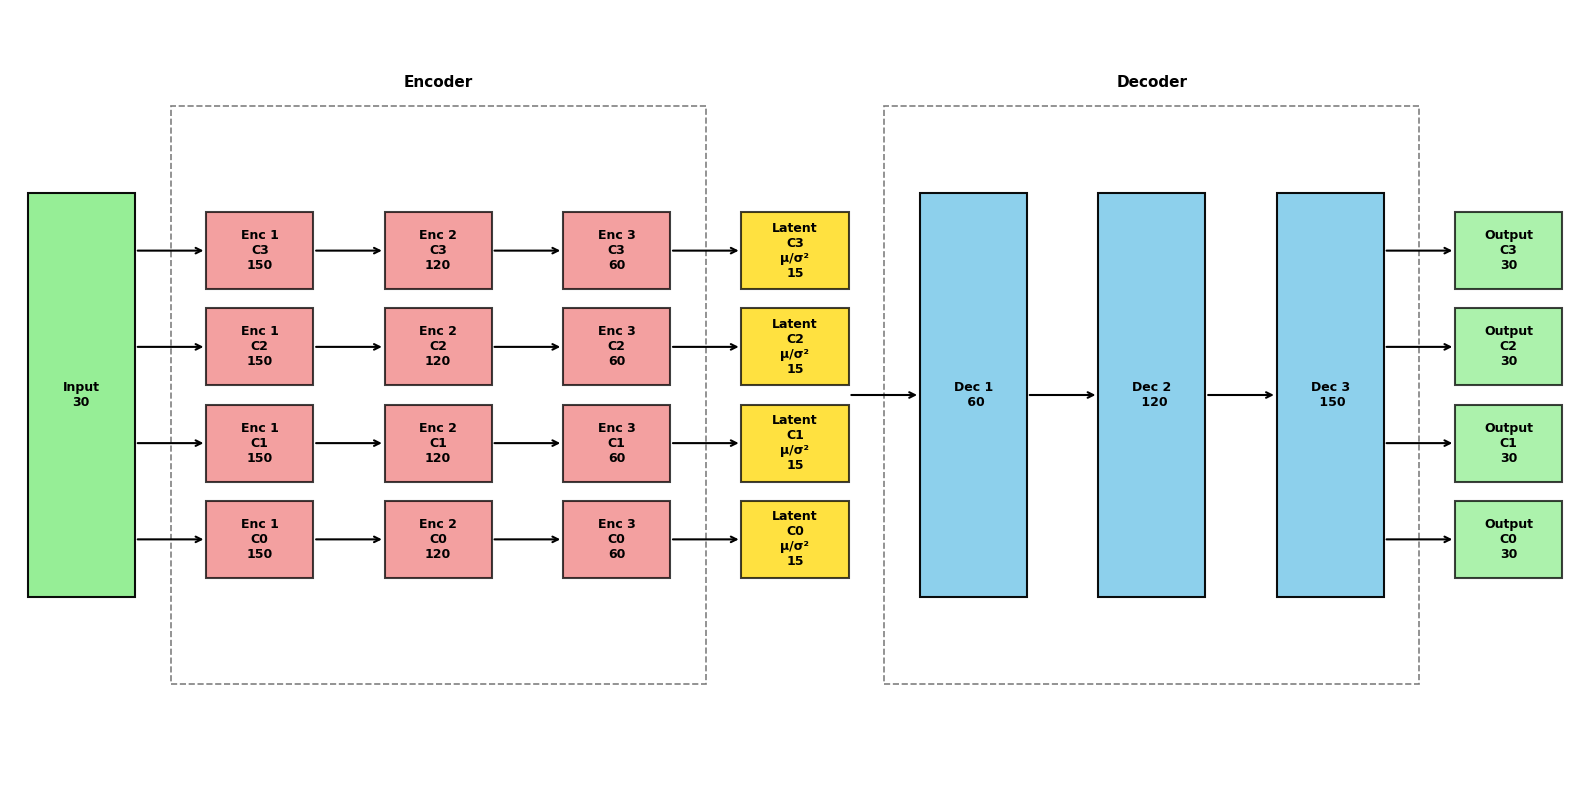

In [6]:
import pandas as pd
from ciss_vae.training.run_cissvae import run_cissvae
from ciss_vae.data import load_example_dataset

# optional, display vae architecture
from ciss_vae.utils.helpers import plot_vae_architecture

data, _, clusters = load_example_dataset()

imputed_data, vae = run_cissvae(data = data,
## Dataset params
    val_proportion = 0.1, ## Fraction of non-missing data held out for validation. Can input a list here if you want different proportions for different clusters. 
    replacement_value = 0.0, 
    columns_ignore = data.columns[:5], ## columns to ignore when selecting validation dataset (and clustering if you do not provide clusters). For example, demographic columns with no missingness.
    print_dataset = True, 

## Cluster params
    clusters = clusters, ## Where your cluster list goes. If none, will do clustering for you  
    n_clusters = None, ## If you want run_cissvae to do clustering and you know how many clusters your data should have, enter that number here
    # -- Params for Leiden Clustering --
    k_neighbors = 15,
    leiden_resolution = 0.5, ## Lower resolution = fewer clusters and bigger clusters, higher resolution = more, smaller clusters
    leiden_objective = "CPM", 
    # -- End Params for Leiden Clustering --
    seed = 42,
    missingness_proportion_matrix = None,
    
## VAE model params
    hidden_dims = [150, 120, 60], ## Dimensions of hidden layers, in order. One number per layer. 
    latent_dim = 15, ## Dimensions of latent embedding
    layer_order_enc = ["unshared", "unshared", "unshared"], ## order of shared vs unshared layers for encode (can use u or s instead of unshared, shared)
    layer_order_dec=["shared", "shared",  "shared"],  ## order of shared vs unshared layers for decode
    latent_shared=False, 
    output_shared=False, 
    batch_size = 4000, ## batch size for data loader
    return_model = True, ## if true, outputs imputed dataset and model, otherwise just outputs imputed dataset. Set to true to return model for `plot_vae_architecture`

## Initial Training params
    epochs = 1000, ## default 
    initial_lr = 0.01, ## default
    decay_factor = 0.999, ## default, factor learning rate is multiplied by after each epoch, prevents overfitting
    beta= 0.001, ## default
    device = None, ## If none, will use gpu if available, cpu if not. See torch.devices for info 

## Impute-refit loop params
    max_loops = 100, ## max number of refit loops
    patience = 2, ## number of loops to check after best_dataset updated. Can increase to avoid local extrema
    epochs_per_loop = None, ## If none, same as epochs
    initial_lr_refit = None, ## If none, picks up from end of initial training
    decay_factor_refit = None, ## If none, same as decay_factor
    beta_refit = None, ## if none, same as beta

## Other params
    verbose = False, 
    return_silhouettes = False, ## if true, will return silhouettes from clustering. If run_cissvae did not perform clustering, will return "None"
    return_history = False, ## if true, will return training MSE history as pandas dataframe
    return_clusters = False, ## if true, will return the cluster labels. Helpful if run_cissvae performs clustering
)

## OPTIONAL - PLOT VAE ARCHITECTURE
plot_vae_architecture(model = vae,
                        title = None, ## Set title of plot
                        ## Colors below are default
                        color_shared = "skyblue", 
                        color_unshared ="lightcoral",
                        color_latent = "gold", # xx fix
                        color_input = "lightgreen",
                        color_output = "lightgreen",
                        figsize=(16, 8),
                        return_fig = False)

Use the `return_clusters` parameter to get the cluster labels.
Use the `return_history` parameter to get a dataframe with the training MSE history.

### Avoiding imputation of certain entries
In some cases, not all missing entries in a dataset are viable for imputation. For example, biomarker values after time of death would not necessarily be reasonable to impute and therefore should be ignored during the impute-refit training loop. To set certain data entries as un-imputable, create a do_not_impute matrix of the same size as the dataset, with 0 for entries that are non-missing or viable for imputation and 1 for entries that are missing and non-viable for imputation. 

This matrix (or pandas.Dataframe) can then be passed to the `run_cissvae()` function. Make sure that the do_not_impute matrix has the same column labels as the original data set to use the `cols_ignore` option to ignore certain columns during imputation. 

For more information, see the [dni vignette](https://ciss-vae.readthedocs.io/en/latest/dni_vignette.html) 

# Hyperparameter Tuning with Optuna

The {py:func}`ciss_vae.training.autotune.autotune` function lets you tune the model's hyperparameters with
optuna to get the best possible model.

## Dataset Preparation

Your dataset should be one of the following:

    - A Pandas DataFrame  

    - A NumPy array  

    - A PyTorch tensor  

Missing values should be represented using np.nan or None.

Once the dataset is loaded, the first step is to identify patterns of
missingness using clustering.

## Clustering on missingness pattern

Before fitting the model, the dataset should clustered based on its
missingness pattern (i.e., which variables are missing in each
observation).

The built-in function can perfrom either leiden clustering or Kmeans clustering:

In [10]:
from ciss_vae.utils.clustering import cluster_on_missing
data, _, clusters = load_example_dataset()
clusters, _ = cluster_on_missing(
    data, 
    cols_ignore=data.columns[:5], 
    n_clusters=None, 
    k_neighbors=500, ## use higher k for fewer clusters generally
    use_snn=True,
    leiden_resolution=0.005, ## higher resolution -> more clusters
    leiden_objective="CPM",
    seed=42)


This function uses Leiden Clustering clustering to detect structure in binary
missingness masks, and will automatically determine the number of
clusters if not specified. If n_clusters is specified, uses KMeans.

**Options:**  
- cols_ignore: list of columns to exclude when computing the missingness
pattern. Ex: identifiers
- n_clusters: set this to use K-Means instead of nonparametric
    clustering.  

**To cluster on proportion of missingness, see (tutorial)[https://ciss-vae.readthedocs.io/en/latest/missingness_prop_vignette.html] for more details.**

# Creating a `ClusterDataset` object

After obtaining cluster labels, construct a {py:class}`ciss_vae.classes.cluster_dataset.ClusterDataset`. This is the object that is fed into the autotune function.

In [ ]:
from ciss_vae.classes.cluster_dataset import ClusterDataset


dataset = ClusterDataset(data = data,
cluster_labels = clusters,
val_proportion = 0.1, ## 10% non-missing data is default. You can also input a list if you want different val_proportions for each cluster
replacement_value = 0, ## value to replace all missing data with before running model. Could be set to 0 or random
columns_ignore = data.columns[:5] ## Tells ClusterDataset not to hold out entries demographic columns for validation
)


## Create a SearchSpace object:

In the SearchSpace object, define the search space for each
hyperparameter. Each of the parameters in {py:class}`ciss_vae.training.autotune.SearchSpace` can be set as
either tunable or non-tunable.

Types of parameters:  
- (min, max, step) -\> creates a range   
- \[a, b, c\] -\> select value from list
- x -\> set param as non-tunable    


In [1]:
from ciss_vae.training.autotune import SearchSpace, autotune
## These are the default parameters. Please note these parameters may not be best for all datasets depending on size and complexity.

searchspace = SearchSpace(
                 num_hidden_layers=(1, 4), ## Set number of hidden layers
                 hidden_dims=[64, 512], ## Allowable dimensions of hidden layers
                 latent_dim=[10, 100],
                 latent_shared=[True, False],
                 output_shared=[True,False],
                 lr=(1e-4, 1e-3),
                 decay_factor=(0.9, 0.999),
                 beta=0.01,
                 num_epochs=1000,
                 batch_size=64,
                 num_shared_encode=[0, 1, 3],
                 num_shared_decode=[0, 1, 3],
                 encoder_shared_placement = ["at_end", "at_start", "alternating", "random"], ## where should the shared layers be placed in the encoder
                 decoder_shared_placement = ["at_end", "at_start", "alternating", "random"], ## where should the shared layers be placed in the decoder
                 refit_patience=2,
                 refit_loops=100,
                 epochs_per_loop = 1000,
                 reset_lr_refit = [True, False])

### Saving and Loading SearchSpace Objects

SearchSpace objects can be saved as json files for future use. To save a SearchSpace object:

In [2]:
searchspace.save("saved_ss.json")

To load a SearchSpace object:

In [3]:
loaded_ss = SearchSpace().load("saved_ss.json")

print(loaded_ss)

SearchSpace(
  num_hidden_layers: [1, 4]  [TUNABLE]
  hidden_dims: [64, 512]  [TUNABLE]
  latent_dim: [10, 100]  [TUNABLE]
  latent_shared: [True, False]  [TUNABLE]
  output_shared: [True, False]  [TUNABLE]
  lr: [0.0001, 0.001]  [TUNABLE]
  decay_factor: [0.9, 0.999]  [TUNABLE]
  weight_decay: 0.001  [FIXED]
  beta: 0.01  [FIXED]
  num_epochs: 1000  [FIXED]
  batch_size: 64  [FIXED]
  num_shared_encode: [0, 1, 3]  [TUNABLE]
  num_shared_decode: [0, 1, 3]  [TUNABLE]
  encoder_shared_placement: ['at_end', 'at_start', 'alternating', 'random']  [TUNABLE]
  decoder_shared_placement: ['at_end', 'at_start', 'alternating', 'random']  [TUNABLE]
  refit_patience: 2  [FIXED]
  refit_loops: 100  [FIXED]
  epochs_per_loop: 1000  [FIXED]
  reset_lr_refit: [True, False]  [TUNABLE]
)


## Run the `autotune` function:

Once the search space is set, the autotune function can be run.

There are a few options for running the autotune function, depending on your goals.   
    1. Default:     
        - Tune on a random sample of parameters from the SearchSpace obbject. This is the traditional autotune behavior.   
        - For this behavior, set `constant_layer_size=False` and `evaluate_all_orders=False`.  
    2. Tune with constant layer size:  
        - All layers will be the same size. The size will be one selected from searchspace. 
        (ex: if `searchspace.num_hidden_layers` = [64, 512], all layers will be 64 or all layers will be 512),  
        - For this behavior, set `constant_layer_size=False`  
    3. Tune for all permutations of shared layer placement:  
        - Will tune all possible layer orders/placements. Use `max_exhaustive_orders` to set a cap on the number of permutations to try.  
        - For this behavior, set `evaluate_all_orders=True`

In [ ]:
best_imputed_df,  best_model, study, results_df = autotune(
    search_space = searchspace,
    train_dataset = dataset,                   # ClusterDataset object
    save_model_path=None,
    save_search_space_path=None,
    n_trials=20,
    study_name="vae_autotune",                 # Default study name
    device_preference="cuda",
    show_progress=False,                       # Show progress bar for training
    optuna_dashboard_db=None,                  # If using optuna dashboard set db location here
    load_if_exists=True,                       # If using optuna dashboard, if study by 'study_name' already exists, will load that study
    seed = 42,                                 # Sets seed for random order of shared/unshared layers
)

[I 2025-10-09 15:52:05,032] A new study created in memory with name: vae_autotune


[Warning] CUDA requested but not available. Falling back to CPU.
Starting Optuna optimization with 20 trials...


/home/nfs/vaithid1/CISS-VAE/CISS-VAE/src/ciss_vae/training/autotune.py:549: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(["Validation MSE"])
[I 2025-10-09 16:12:32,538] Trial 0 finished with value: {'Validation MSE': 5.61246919631958} and parameters: {'num_hidden_layers': 1, 'hidden_dim_0': 512, 'latent_dim': 10, 'latent_shared': True, 'output_shared': True, 'lr': 0.00039843586858746887, 'decay_factor': 0.9684395881174177, 'num_shared_encode': 3, 'num_shared_decode': 0, 'encoder_shared_placement': 'at_start', 'decoder_shared_placement': 'at_end', 'reset_lr_refit': False}. Best is trial 0 with value: 5.61246919631958.



## (optional) Using Optuna Dashboard

You can use [optuna
dashboard](https://optuna-dashboard.readthedocs.io/en/stable/getting-started.html)
to visualize the importance of your tuning parameters. If you use VSCode
or [Positron](https://positron.posit.co/download.html) there is an
extension for viewing optuna dashboards in your development environment.

![Screenshot of Optuna Dashboard](optuna_dash_v1.png)

The optuna database file can be opened via commandline as well. (tutorial)[https://optuna-dashboard.readthedocs.io/en/stable/getting-started.html#command-line-interface]  


To use optuna dashboard, set your database url in the autotune function. You
can have multiple autotune 'studies' in the same database.

In [ ]:
best_imputed_df,  best_model, study, results_df = autotune(
    search_space = searchspace,
    train_dataset = dataset,                   # 'ClusterDataset' object
    save_model_path=None,
    save_search_space_path=None,
    n_trials=20,
    study_name="vae_autotune",                 # Default study name
    device_preference="cuda",
    show_progress=False,                       # Show progress bar for training
    optuna_dashboard_db="sqlite:///db.sqlite3",                  # If using optuna dashboard set db location here, otherwise set to None
    load_if_exists=True,                       # Continues previous study by study_name if one exists. If false, will give error if study_name already exists in the set dashboard
    seed = 42,
)




# Saving and loading models

## Saving

If you want to save your model and load it later, there are two options.

To save the model weights after training:

``` python
## assuming your trained model is called 'model'
import torch

torch.save(model.state_dict(), "trained_vae.pt")
```

If you want to save the entire model:

``` python
torch.save(model, "trained_vae_full.pt")
```

## Loading a Model

To reload the model for imputation or further training:   
1. Re-create the model architecture with the same settings used during training  
2. Load the saved weights  

``` python
from ciss_vae.classes.vae import CISSVAE

# 1. Define the architecture (must match the saved model!)
model = CISSVAE(
    input_dim=...,
    hidden_dims=[...],
    layer_order_enc=[...],
    layer_order_dec=[...],
    latent_shared=...,
    num_clusters=...,
    latent_dim=...,
    output_shared=...
)
model.load_state_dict(torch.load("trained_vae.pt"))



## optional to get imputed dataset. 
from ciss_vae.utils.helpers import get_imputed_df
from torch.utils.data import DataLoader

## assuming dataset is a ClusterDataset
data_loader =  DataLoader(dataset, batch_size=4000)

imputed_df = get_imputed_df(model, data_loader)
```
